In [219]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings(action='ignore') #default
import pyfolio as pf

In [238]:
class TaticsClass(object):
  @staticmethod
  def AW4_11(iter_date):
    AW_4_  = (iter_date.month==4)
    AW_11_ = (iter_date.month==11)
    if (AW_4_ or AW_11_):
      pivot_date = SimUtils.get_pivot(iter_date.year,iter_date.month,28)
    else:
      pivot_date = None
    return pivot_date

  @staticmethod
  def BuyAndHold(iter_date):
    return None

  @staticmethod
  def FastTatics(iter_date):
    pivot_date = iter_date
    return pivot_date



class Tatics(object):
  @staticmethod
  def DualMomentum(simenv, trading_df):
    #print(trading_df[simenv.tickers])
    trading_df[[ etf+'_back12' for etf in simenv.tickers]] = trading_df[simenv.tickers].shift(periods=365).rolling(window=55).mean()
    trading_df = trading_df.dropna()
    #trading_df = trading_df.iloc[365:]

    dualmomentum_df = pd.DataFrame()
    for etf in simenv.tickers:
      dualmomentum_df[ etf ] = (trading_df[etf] - trading_df[etf+'_back12'])/trading_df[etf+'_back12'] * 100

    #print(dualmomentum_df)

    trading_df = trading_df.assign(pick =dualmomentum_df.idxmax(axis=1) )
    return trading_df

  @staticmethod
  def Default(simenv, trading_df):
    return trading_df


In [239]:
class SimEnv(object):
  name         = 'AllWeather'
  tickers      = ['QQQ','GLD']
  ratios       = [0.5, 0.5]
  start_date   = '2018-10-30'
  end_date     = '2022-04-01'
  init_capital = 1_000_000
  tatic        = Tatics.DualMomentum
  tatic_class  = TaticsClass.FastTatics
  interest_rate= 1.1

class SimPreprocessing(object):
  def __init__(self, env:SimEnv):
    env.start_date = datetime.datetime.strptime(env.start_date, '%Y-%m-%d')
    env.end_date   = datetime.datetime.strptime(env.end_date, '%Y-%m-%d')
    
    path = 'fsdata/'+env.name+'.csv'
    if os.path.exists(path):
      trading_df = pd.read_csv(path)
      trading_df.set_index(keys='Unnamed: 0',inplace=True)
      trading_df.index.name = None
      trading_df.index = pd.to_datetime(trading_df.index)
    
    else:
      df_price = self.preprocess(env.tickers)
      trading_df = self.make_trading_df(df_price, env.tickers)
      trading_df.to_csv(path, index=True, date_format='%Y-%m-%d')

    env.tickers.append('CMA')
    env.ratios.append(1-sum(env.ratios))
  
    days = len(trading_df)
    day_income_percent = (simenv.interest_rate/365/100) * (1-0.154)
    cma_lambda = (lambda x: (1+day_income_percent)**x)
    trading_df = trading_df.assign(CMA=cma_lambda(np.arange(0, days)))

    self.trading_df = self.load_tatics(env, trading_df)


  def load_tatics(self, env, trading_df):
    loaded_df = env.tatic(env, trading_df)
    return loaded_df

  def get_trading_df(self):
    return self.trading_df

  def get_portpolio(self, tickers:list):
    yf.pdr_override()
    df_price = pdr.get_data_yahoo(tickers)
    df_price.isnull().sum()
    df_price.dropna(axis=0,inplace=True)
    return df_price

  def preprocess(self, tickers:list):
    df_price = self.get_portpolio(tickers)
    start = df_price.index[0] 
    end   = df_price.index[-1]
    df_new_index = pd.date_range(start,end)
    df_price = df_price.reindex(df_new_index)

    df_price.isna().sum()
    df_price.replace(np.NaN, 0, inplace=True)

    for today in df_price.index[1:]:
      for col in df_price.columns.values:
        if df_price[col][today] == 0:
          df_price[col][today] = df_price[col][today-datetime.timedelta(days=1)]

    return df_price

  def make_trading_df(self,df_price, tickers):
    trading_df = pd.DataFrame(df_price['Close'])
    trading_df[[etf+'_qty' for etf in tickers]]     = 0
    trading_df[[etf+'_capital' for etf in tickers]] = 0
    trading_df['Total'] = 0
    return trading_df

In [240]:
import datetime
from dateutil import relativedelta

class SimUtils(object):
  @staticmethod
  def get_pivot(year, month, day):
    pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
    return pivot_date

  @staticmethod
  def get_next_month(today:datetime):
      nextmonth = today + relativedelta.relativedelta(months=1)
      return nextmonth

  @staticmethod
  def set_reblancing_date(trading_df, Func, start_date, end_date):
    tdf= trading_df.copy()
    tdf['Pivot'] = 0
    tdf.loc[start_date,'Pivot'] = 1
    tdf.loc[end_date,'Pivot'] = 1
    iter_date = start_date

    while iter_date < end_date:
      pivot_date = Func(iter_date)
      if pivot_date:
        tdf.loc[pivot_date,'Pivot'] = 1 
      iter_date = SimUtils.get_next_month(iter_date)
    return tdf

  @staticmethod
  def init_result_columns(trading_df, init_capital, tickers):
    capital = init_capital
    trading_df['Total'] = trading_df[[etf+'_capital' for etf in tickers]].sum(axis=1)
    trading_df['Yield'] = (trading_df['Total']-capital)/capital*100
    trading_df['MDD'] = 0
    trading_df['MDD_FULL'] = 0
    return trading_df


In [241]:
class SimEngine(SimUtils):
  DEBUG = False
  def __init__(self, simenv:SimEnv, sim_preprocessing:SimPreprocessing):
    self.env = simenv
    period     = (self.env.start_date <= sim_preprocessing.trading_df.index) & (self.env.end_date >= sim_preprocessing.trading_df.index)
    self.trading_df = sim_preprocessing.trading_df.loc[period]

  @staticmethod
  def buy_portpolio(trading_df, init_capital ,tickers, ratios):
    capital = init_capital
    budgets = (np.ones(len(tickers))*capital)*ratios
    qtys   = (budgets/ trading_df.loc[trading_df.index[0],tickers].values).astype(int)

    for i, etf in enumerate(tickers):
      trading_df.loc[:,etf+'_qty'] = qtys[i] 
      trading_df[etf+'_capital'] = trading_df[etf+'_qty']*trading_df[etf]

    return trading_df

  def Run(self):
    env = self.env
    trading_df = SimUtils.set_reblancing_date(self.trading_df, env.tatic_class, env.start_date, env.end_date)
    trading_df = SimEngine.buy_portpolio(trading_df, env.init_capital, env.tickers, env.ratios)
    trading_df = SimUtils.init_result_columns(trading_df, env.init_capital, env.tickers)

    # Reblancing
    index = trading_df.loc[trading_df['Pivot']==True, :].index.values
    reference_column = 'Total'

    for i in range(len(index)-1):
      period = (index[i] <= trading_df.index) & (index[i+1] >= trading_df.index)
      quater_df = trading_df.loc[period,:].copy()
      if len(quater_df) == 0:
        break

      quater_capital = 0
      for etf in env.tickers:
        quater_capital = quater_capital + quater_df.iloc[0].xs(etf+'_capital')

      '''
      # ================================================#
          Apply Tatic:
      # ================================================#
      '''
      if 'pick' in quater_df.columns:
        pick = quater_df.iloc[0]['pick']
        env.ratios = [0] * len(env.ratios)
        env.ratios[env.tickers.index(pick)] = 1
        #print( env.ratios, env.tickers.index(pick),pick)

      quater_df = SimEngine.buy_portpolio(quater_df, quater_capital, env.tickers,env.ratios)
      quater_df = SimUtils.init_result_columns(quater_df,quater_capital,env.tickers)

      trading_df.loc[period,:] = quater_df

    trading_df[reference_column].plot()
    plt.legend()
    plt.show()

    return trading_df

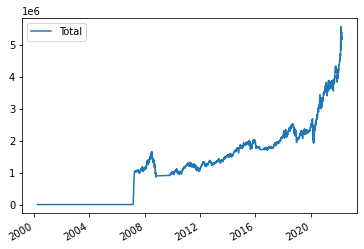

KeyError: 'Total'

In [245]:
if 0:
    simenv = SimEnv()
    simenv.name         = 'AllWeather'
    simenv.tickers      = ['QQQ','GLD','IEF']
    simenv.ratios       = [0.25, 0.25, 0.25]
    simenv.start_date   = '2016-04-03'
    simenv.end_date     = '2022-05-01'
    simenv.init_capital = 1_000_000
    simenv.interest_rate = 2

    simenv.tatic        = Tatics.Default
    simenv.tatic_class  = TaticsClass.BuyAndHold
    simpp  = SimPreprocessing(simenv)
    sim    = SimEngine(simenv, simpp)
else:
    simenv = SimEnv()
    simenv.name         = 'DualMomentum'
    simenv.tickers      = ['QQQ','SPY','EFA','DBC']
    simenv.ratios       = [1/len(simenv.tickers)]*len(simenv.tickers)
    simenv.start_date   = '2000-04-03'
    simenv.end_date     = '2022-04-03'
    simenv.init_capital = 1_000_000
    simenv.interest_rate = 2

    simenv.tatic        = Tatics.DualMomentum
    simenv.tatic_class  = TaticsClass.FastTatics
    simpp  = SimPreprocessing(simenv)
    sim    = SimEngine(simenv, simpp)
if 0:
    result_df = sim.Run()
    result_df['MDD_FULL'].plot(label='Max Drawdown [%]')
    result_df['MDD'].plot(label='Local Max Drawdown [%]')
    plt.legend()
    plt.show()

    num_year = max(simenv.end_date.year - simenv.start_date.year, 1)
    yield_ = (result_df['Total'][-1]/result_df['Total'][0])
    cagr = ((yield_)**(1/num_year) - 1)*100
    print('Yield: %.2f [%%], CAGR: %.2f [%%]'%(yield_*100, cagr))
else:
    result_df = sim.Run()
    df = df['Total'].pct_change()#.fillna(0)
    pf.create_returns_tear_sheet(df)
